# Running an MSTIS simulation using the constrained shooting algorithm

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation using constrained shooting. This notebook is a adaptation of the standard MSTIS toy model exaample.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Ways of assigning initial trajectories to initial samples
* Setting up a path sampling simulation with various move schemes
* Visualizing trajectories while the path sampling is running

In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np
from IPython.display import SVG
import openpathsampling.visualize as vis

### Loading things from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [2]:
old_store = paths.AnalysisStorage("mstis_bootstrap.nc")

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [3]:
print("PathMovers: "+ str(len(old_store.pathmovers)))
print("Samples: " +  str(len(old_store.samples)))
print("Ensembles: " + str(len(old_store.ensembles)))
print("SampleSets: " + str(len(old_store.samplesets)))
print("Snapshots: " + str(len(old_store.snapshots)))
print("Networks: " + str(len(old_store.networks)))

PathMovers: 0
Samples: 10
Ensembles: 100
SampleSets: 1
Snapshots: 650
Networks: 0


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create. There's only one engine stored, so we take the only one.

In [4]:
template = old_store.snapshots[0]

In [5]:
engine = old_store.engines[0]

Named objects can be found in storage by using their name as a dictionary key. This allows us to load our old collective variables and states.

In [6]:
opA = old_store.cvs['opA']
opB = old_store.cvs['opB']
opC = old_store.cvs['opC']

In [7]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']

In [8]:
# we could also load the interfaces, but it takes less code to build new ones:
interfacesA = paths.VolumeInterfaceSet(opA, 0.0,[0.2, 0.3, 0.4])
interfacesB = paths.VolumeInterfaceSet(opB, 0.0,[0.2, 0.3, 0.4])
interfacesC = paths.VolumeInterfaceSet(opC, 0.0,[0.2, 0.3, 0.4])

Once again, we have everything we need to build the MSTIS network. Recall that this will create all the ensembles we need for the simulation. However, even though the ensembles are semantically the same, these are not the same objects. We'll need to deal with that later.

In [9]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: 0.5 
     for ifaces in [interfacesA, interfacesB, interfacesC]}
)
mstis = paths.MSTISNetwork(
    [(stateA, interfacesA),
     (stateB, interfacesB),
     (stateC, interfacesC)],
    ms_outers=ms_outers
)

Now we need to set up real trajectories that we can use for each of these. We can start by loading the stored sampleset.

In [10]:
# load the sampleset we have saved before
old_sampleset = old_store.samplesets[0]

### Remapping old ensembles to new ensembles

If your old and new ensembles have the same string representations, then OPS has a function to help you automatically map them. As long as you create the ensembles in the same way, they'll have the same string representation. Note that if you *don't* have the same string representation, you would have to assign trajectories to ensembles by hand (which isn't that hard, but is a bit tedious).

In [11]:
sset = paths.SampleSet.translate_ensembles(old_sampleset, mstis.sampling_ensembles)

In [12]:
sset.sanity_check()
assert(len(sset)==9)

### Setting up special ensembles

Whichever way we initially set up the `SampleSet`, at this point it only contains samples for the main sampling trajectories of each transition. Now we need to put trajectories into various auxiliary ensembles.

#### Multiple state outer ensemble

The multiple state outer ensemble is, in fact, sampled during the bootstrapping. However, it is actually sampled once for every state that shares it. It is very easy to find a trajectory that satisfies the ensemble and to load add that sample to our sampleset.

In [13]:
for outer_ens in mstis.special_ensembles['ms_outer']:
    # doesn't matter which we take, so we take the first
    traj = next(s.trajectory for s in old_sampleset if outer_ens(s.trajectory)==True)
    samp = paths.Sample(
            replica=None,
            ensemble=outer_ens,
            trajectory=traj
    )
    # now we apply it and correct for the replica ID
    sset.append_as_new_replica(samp)

In [14]:
sset.sanity_check()
assert(len(sset)==10)

#### Minus interface ensemble

The minus interface ensembles do not yet have a trajectory. We will generate them by starting with same-state trajectories (A-to-A, B-to-B, C-to-C) in each interface, and extending into the minus ensemble.

* check whether the traj is A-to-A
* extend

First we need to make sure that the trajectory in the innermost ensemble of each state also ends in that state. This is necessary so that when we extend the trajectory, it can extends into the minus ensemble.

If the trajectory isn't right, we run a shooting move on it until it is.

In [15]:
for transition in mstis.sampling_transitions:
    innermost_ensemble = transition.ensembles[0]
    shooter = None
    if not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        shooter = paths.OneWayShootingMover(ensemble=innermost_ensemble,
                                            selector=paths.UniformSelector(),
                                            engine=engine)
        pseudoscheme = paths.LockedMoveScheme(root_mover=shooter)
        pseudosim = paths.PathSampling(storage=None, 
                                       move_scheme=pseudoscheme, 
                                       sample_set=sset,
                                      )
    while not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        pseudosim.run(1)
        sset = pseudosim.sample_set

    

Now that all the innermost ensembles are safe to use for extending into a minus interface, we extend them into a minus interface:

In [16]:
minus_samples = []
for transition in mstis.sampling_transitions:
    minus_samples.append(transition.minus_ensemble.extend_sample_from_trajectories(
        sset[transition.ensembles[0]].trajectory,
        replica=-len(minus_samples)-1,
        engine=engine
    ))
sset = sset.apply_samples(minus_samples)

In [17]:
sset.sanity_check()
assert(len(sset)==13)

## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [18]:
equil_scheme = paths.OneWayShootingMoveScheme(mstis, engine=engine)

In [19]:
equilibration = paths.PathSampling(
    storage=None,
    sample_set=sset,
    move_scheme=equil_scheme
)

In [20]:
#! skip
# tests need the unequilibrated samples to ensure passing
equilibration.run(5)

Working on Monte Carlo cycle number 5
Running for 0 seconds -  0.22 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 5 Monte Carlo cycles.


In [21]:
sset = equilibration.sample_set

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [22]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)

In [23]:
storage = paths.storage.Storage("constrained_mstis.nc", "w")

Now make and show the default move scheme, so we can later compare it to the scheme with the constrained shooting.

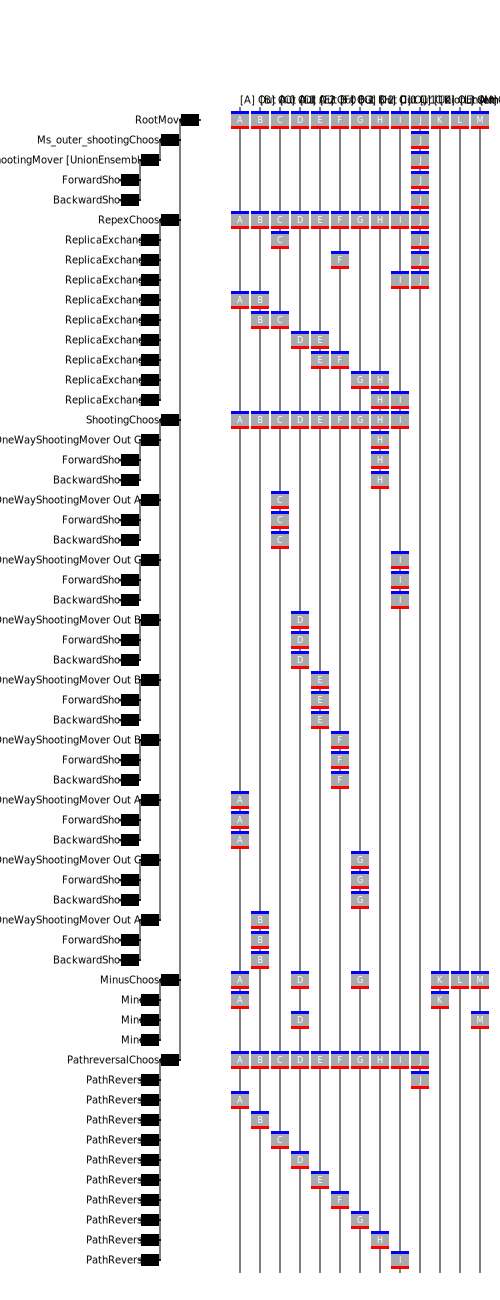

In [24]:
scheme = paths.DefaultScheme(mstis, engine=engine)
move_vis = vis.MoveTreeBuilder.from_scheme(scheme, hidden_ensembles=False)
#move_vis.options.analysis['only_canonical']=False
SVG(move_vis.svg())

Now make the interface constrained shooting move scheme. 

In [25]:
from openpathsampling.high_level import move_strategy

scheme = paths.DefaultScheme(mstis, engine=engine)
listofselectors = [paths.InterfaceConstrainedSelector(ens.interface)
                   for ens in mstis.sampling_ensembles]
constrained_strategy = move_strategy.ForwardShootingStrategy(selector=listofselectors,
                                                             ensembles=mstis.sampling_ensembles,
                                                             engine=engine)
scheme.append(constrained_strategy)


Visualise the scheme that uses interface constrained shooting. Note that the only difference with the default scheme is in the shooting part, where we only use forward shooting.

Some things you might observe:
* The `ForwardShootingStrategy` replaces the `'shooting'` group, and therefore shooting in the MS-outer interface still isn't changed.
* Interface constrained shooting only using a `ForwardShootingStrategy`. This means that it is absolutely essential that `PathReversalMover`s are part of the move scheme -- otherwise, the sampling would not be ergodic.

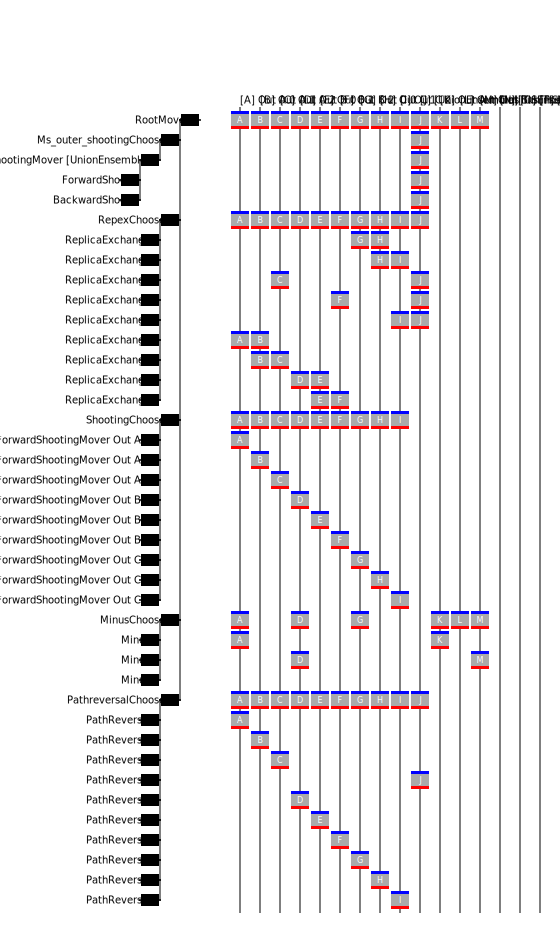

In [26]:
scheme.build_move_decision_tree()
move_vis=vis.MoveTreeBuilder.from_scheme(scheme)
SVG(move_vis.svg())

By looking at the `to_dict` method for a mover, we can see that it does, in fact, use the `InterfaceConstrainedSelector`.

In [27]:
scheme.movers['shooting'][0].to_dict()

{'_engine': <openpathsampling.engines.toy.engine.ToyEngine at 0x103e50890>,
 'engine': <openpathsampling.engines.toy.engine.ToyEngine at 0x103e50890>,
 'ensemble': <openpathsampling.ensemble.TISEnsemble at 0x10f0b7410>,
 'selector': <openpathsampling.shooting.InterfaceConstrainedSelector at 0x110302f90>,
 'target_ensemble': <openpathsampling.ensemble.TISEnsemble at 0x10f0b7410>}

In [28]:
mstis_calc = paths.PathSampling(
    storage=storage,
    sample_set=sset,
    move_scheme=scheme
)
mstis_calc.save_frequency = 50

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

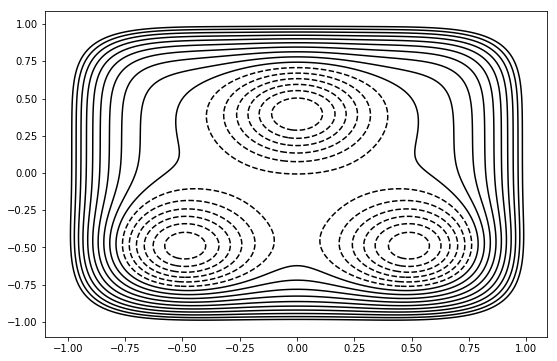

In [29]:
#! skip
# skip this during testing, but leave it for demo purposes
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py
xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
mstis_calc.live_visualizer = paths.StepVisualizer2D(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(engine.pes)
mstis_calc.live_visualizer.background = background.plot()
mstis_calc.status_update_frequency = 1 # increasing this number speeds things up, but isn't as pretty

Now everything is ready: let's run the simulation!

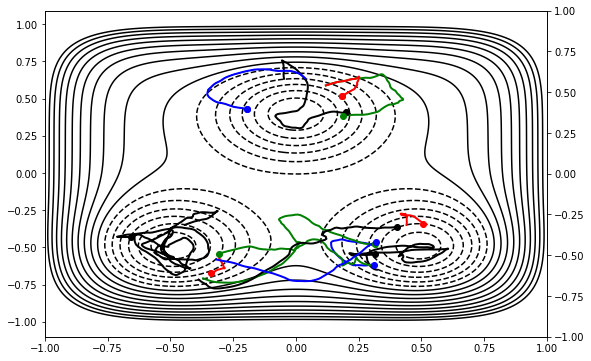

DONE! Completed 100 Monte Carlo cycles.


In [30]:
mstis_calc.run_until(100)

Now we perform some basic analysis. First, we look at the acceptance. Note that the shooting now has 100% acceptance; this is one of the advantages of interface constrained shooting.

In [31]:
scheme.move_summary(storage.steps)

ms_outer_shooting ran 5.000% (expected 4.98%) of the cycles with acceptance 4/5 (80.00%)
repex ran 22.000% (expected 22.39%) of the cycles with acceptance 12/22 (54.55%)
shooting ran 43.000% (expected 44.78%) of the cycles with acceptance 43/43 (100.00%)
minus ran 3.000% (expected 2.99%) of the cycles with acceptance 3/3 (100.00%)
pathreversal ran 27.000% (expected 24.88%) of the cycles with acceptance 20/27 (74.07%)


Next we build a path tree. Note that there are only forward shots, and successive forward shots (without a path reversal or replica exchange between them) will always have the same shooting point.

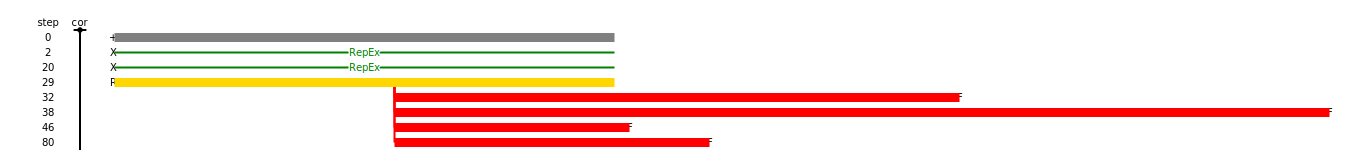

In [32]:
tree = vis.PathTree(
    storage.steps[0:100],
    vis.ReplicaEvolution(replica=0)
)
tree.options.movers['ReplicaExchangeMover']['hide'] = False

SVG(tree.svg())

In [33]:
len(storage.steps)

101

In [34]:
storage.close()